<a href="https://colab.research.google.com/github/vikramkrishnan9885/MyColab/blob/master/BasicsOfGluonTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup MXNet

In [1]:
!pip install spacy==2.0.18 folium==0.2.1 imgaug==0.2.7
!pip install --upgrade numpy
!pip install -q mxnet-cu101
!pip install gluonts

!nvcc --version

Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.19.1)
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


# Imports

In [2]:
from gluonts.dataset import common
from gluonts.model import deepar
from gluonts.trainer import Trainer

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Basic example

## Data proc

In [4]:
url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_AMZN.csv"
df = pd.read_csv(url, header=0, index_col=0)
df.head(5)

,value
timestamp,
2015-02-26 21:42:53,57
2015-02-26 21:47:53,43
2015-02-26 21:52:53,55
2015-02-26 21:57:53,64
2015-02-26 22:02:53,93


In [6]:
data = common.ListDataset(
    [
     {
         "start": df.index[0],
         "target": df.value[:"2015-04-05 00:00:00"]
     }
    ],
    freq="5min"
)
data

## TEP

In [8]:
trainer = Trainer(epochs=10)
estimator = deepar.DeepAREstimator(
    freq="5min", 
    prediction_length=12, 
    trainer=trainer
)
predictor = estimator.train(training_data=data)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:06<00:00,  8.08it/s, epoch=10/10, avg_epoch_loss=3.96]


## Plot

[49.796253 49.67718  43.20441  44.380653 43.149174 43.56647  40.690567
 42.710518 43.255035 40.900623 43.21005  41.218685]


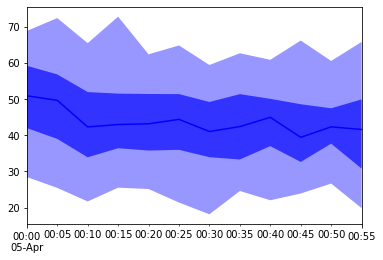

In [9]:
prediction = next(predictor.predict(data))
print(prediction.mean)
prediction.plot()

# Basics

GluonTS contains:
* Components for building new models (likelihoods, feature processing pipelines, calendar features etc.)
* Data loading and processing
* A number of pre-built models
* Plotting and evaluation facilities
* Artificial and real datasets (only external datasets with blessed license)

## GluonTS datasets

In [10]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

In [12]:
print('Names of datasets are:',list(dataset_recipes.keys()))

Names of datasets are: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5']


In [13]:
dataset_recipes.values()

odict_values([functools.partial(<function generate_artificial_dataset at 0x7f0cfd3d5f28>, dataset=<gluonts.dataset.artificial._base.ConstantDataset object at 0x7f0cfd895c50>), functools.partial(<function generate_lstnet_dataset at 0x7f0cfd2ebae8>, dataset_name='exchange_rate'), functools.partial(<function generate_lstnet_dataset at 0x7f0cfd2ebae8>, dataset_name='solar-energy'), functools.partial(<function generate_lstnet_dataset at 0x7f0cfd2ebae8>, dataset_name='electricity'), functools.partial(<function generate_lstnet_dataset at 0x7f0cfd2ebae8>, dataset_name='traffic'), functools.partial(<function generate_gp_copula_dataset at 0x7f0cfd34f620>, dataset_name='exchange_rate_nips'), functools.partial(<function generate_gp_copula_dataset at 0x7f0cfd34f620>, dataset_name='electricity_nips'), functools.partial(<function generate_gp_copula_dataset at 0x7f0cfd34f620>, dataset_name='traffic_nips'), functools.partial(<function generate_gp_copula_dataset at 0x7f0cfd34f620>, dataset_name='solar_n

In [17]:
dataset_recipes['exchange_rate']

functools.partial(<function generate_lstnet_dataset at 0x7f0cfd2ebae8>, dataset_name='exchange_rate')

* To download one of the built-in datasets, simply call `get_dataset` with one of the above names. 
* GluonTS can re-use the saved dataset so that it does not need to be downloaded again: simply set `regenerate=False`.
* In general, the datasets provided by GluonTS are objects that consists of three main members:
  * `dataset.train` is an iterable collection of data entries used for training. Each entry corresponds to one time series
  * `dataset.test` is an iterable collection of data entries used for inference. The test dataset is an extended version of the train dataset that contains a window in the end of each time series that was not seen during training. This window has length equal to the recommended prediction length.
  * `dataset.metadata` contains metadata of the dataset such as the frequency of the time series, a recommended prediction horizon, associated features, etc

In [18]:
dataset = get_dataset("m4_hourly", regenerate=True)

saving time-series into /root/.mxnet/gluon-ts/datasets/m4_hourly/train/data.json
saving time-series into /root/.mxnet/gluon-ts/datasets/m4_hourly/test/data.json


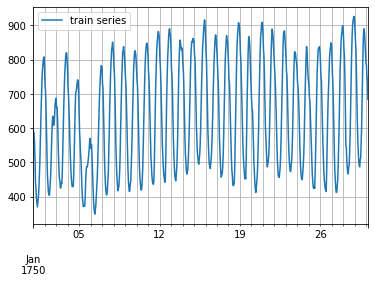

In [22]:
# TRAIN DATASET

entry = next(iter(dataset.train))
train_series = to_pandas(entry)

train_series.plot()

plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

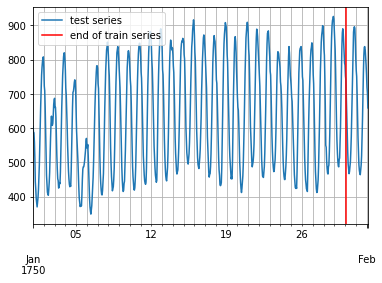

In [23]:
# TEST DATASET
entry = next(iter(dataset.test))
test_series = to_pandas(entry)

test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset

plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [24]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


# Custom datasets

The only requirements for a custom dataset are:
1. to be iterable and 
2. have:  
  1. a "target" field and 
  2. a "start" field. 

To make this more clear, assume the common case where:
* a dataset is in the form of a numpy.array and 
* the index of the time series in a pandas.Timestamp


In [25]:
from gluonts.dataset.common import ListDataset

In [26]:
N = 10  # number of time series
T = 100  # number of timesteps
custom_dataset = np.random.normal(size=(N, T))

freq = "1H"
start = pd.Timestamp("01-01-2019", freq=freq)  # can be different for each time series

In [27]:
prediction_length = 24

# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(
    [
     {'target': x, 'start': start}
      for x in custom_dataset[:, :-prediction_length]
    ],
    freq=freq
)

# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(
    [
      {'target': x, 'start': start}
      for x in custom_dataset
     ],
    freq=freq
)

# GluonTS Estimators and Predictors

GluonTS comes with a number of pre-built models. All the user needs to do is configure some hyperparameters. The existing models focus on (but are not limited to) __probabilistic forecasting__. Probabilistic forecasts are predictions in the form of a __probability distribution, rather than simply a single point estimate__.

## Feedforward

GluonTS’s built-in feedforward neural network (`SimpleFeedForwardEstimator`) accepts an input window of length `context_length` and predicts the __distribution__ of the values of the subsequent `prediction_length` values. 

In GluonTS parlance, __the feedforward neural network model is an example of Estimator__. In GluonTS, Estimator objects __represent a forecasting model as well as details such as its coefficients, weights__, etc.


In [28]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.trainer import Trainer

In [29]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    freq=dataset.metadata.freq,
    trainer=Trainer(ctx="cpu",
                    epochs=5,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100
                   )
)

In [30]:
predictor = estimator.train(dataset.train)

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:00<00:00, 102.71it/s, epoch=5/5, avg_epoch_loss=4.76]


GluonTS comes with the make_evaluation_predictions function that automates the process of prediction and model evaluation. Roughly, this function performs the following steps:
* Removes the final window of length prediction_length of the dataset.test that we want to predict
* The estimator uses the remaining data to predict (in the form of sample paths) the "future" window that was just removed
* The module outputs the forecast sample paths and the dataset.test (as python generator objects)

In [31]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [40]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

# First, we can convert these generators to lists to ease the subsequent computations.
forecasts = list(forecast_it)
tss = list(ts_it)

In [42]:
tss

[                         0
 1750-01-01 00:00:00  605.0
 1750-01-01 01:00:00  586.0
 1750-01-01 02:00:00  586.0
 1750-01-01 03:00:00  559.0
 1750-01-01 04:00:00  511.0
 ...                    ...
 1750-01-31 23:00:00  785.0
 1750-02-01 00:00:00  756.0
 1750-02-01 01:00:00  719.0
 1750-02-01 02:00:00  703.0
 1750-02-01 03:00:00  659.0
 
 [748 rows x 1 columns],                           0
 1750-01-01 00:00:00  3124.0
 1750-01-01 01:00:00  2990.0
 1750-01-01 02:00:00  2862.0
 1750-01-01 03:00:00  2809.0
 1750-01-01 04:00:00  2544.0
 ...                     ...
 1750-01-31 23:00:00  3558.0
 1750-02-01 00:00:00  3488.0
 1750-02-01 01:00:00  3224.0
 1750-02-01 02:00:00  3054.0
 1750-02-01 03:00:00  2918.0
 
 [748 rows x 1 columns],                           0
 1750-01-01 00:00:00  1828.0
 1750-01-01 01:00:00  1806.0
 1750-01-01 02:00:00  1897.0
 1750-01-01 03:00:00  1750.0
 1750-01-01 04:00:00  1679.0
 ...                     ...
 1750-01-31 23:00:00  1791.0
 1750-02-01 00:00:00  1819.0
 17

In [34]:
# first entry of the time series list
ts_entry = tss[0]
ts_entry

,0
1750-01-01 00:00:00,605.0
1750-01-01 01:00:00,586.0
1750-01-01 02:00:00,586.0
1750-01-01 03:00:00,559.0
1750-01-01 04:00:00,511.0
...,...
1750-01-31 23:00:00,785.0
1750-02-01 00:00:00,756.0
1750-02-01 01:00:00,719.0
1750-02-01 02:00:00,703.0


In [36]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(-1,)

array([605., 586., 586., 559., 511.], dtype=float32)

In [37]:
# first entry of dataset.test
dataset_test_entry = next(iter(dataset.test))

In [38]:
# first 5 values
dataset_test_entry['target'][:5]

array([605., 586., 586., 559., 511.], dtype=float32)

In [43]:
forecasts

* The entries in the forecast list are a bit more complex. 
* They are objects that contain:
  * all the sample paths in the form of numpy.ndarray with dimension (num_samples, prediction_length), 
  * the start date of the forecast, 
  * the frequency of the time series, etc. 
* We can access all these information by simply invoking the corresponding attribute of the forecast object.

In [44]:
# first entry of the forecast list
forecast_entry = forecasts[0]

print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 48)
Start date of the forecast window: 1750-01-30 04:00:00
Frequency of the time series: H


We can also do calculations to summarize the sample paths, such computing the mean or a quantiles

In [45]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [663.5747  589.0975  554.94653 588.8626  467.25876 490.9614  487.44223
 469.4534  494.93405 538.73804 596.9486  657.4192  747.2141  815.02234
 872.68286 918.90344 881.1554  858.9172  884.5672  868.6768  850.55896
 790.07983 760.1135  663.7954  677.7821  586.44617 590.61896 544.68787
 516.5154  492.95618 468.90765 498.1148  483.78778 556.3746  626.398
 681.0454  772.10065 785.0822  840.826   922.33685 883.3233  868.09
 807.5909  855.1287  876.52765 811.7979  755.3281  753.56555]
0.5-quantile (median) of the future window:
 [664.5889  584.4791  549.04297 598.6632  463.03656 477.683   500.4767
 480.74655 499.68857 532.5467  615.5868  648.63745 737.94495 834.6592
 880.8092  918.41046 878.5534  873.92975 889.04767 867.12866 842.2221
 779.5494  755.17676 660.11957 670.07043 587.2498  592.8857  543.36865
 511.8983  486.67474 479.9926  503.6367  496.67096 575.8369  626.76495
 663.0953  787.21545 789.94037 848.29    919.4617  895.2467  886.7693
 791.1978  875.2597  8

In [46]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

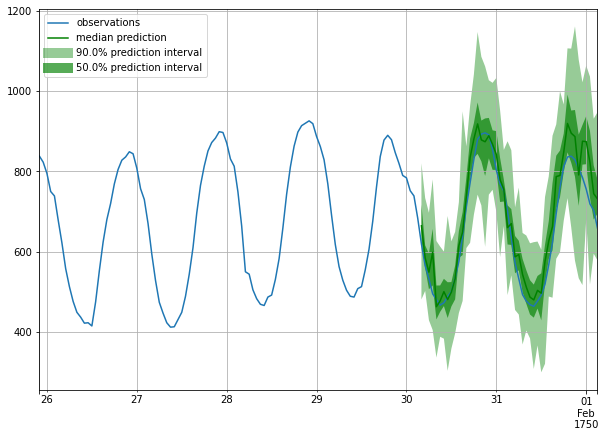

In [47]:
plot_prob_forecasts(ts_entry, forecast_entry)

We can also evaluate the quality of our forecasts numerically. 

In GluonTS, the Evaluator class can compute aggregate performance metrics, as well as metrics per time series (which can be useful for analyzing performance across heterogeneous time series).

In [50]:
import json
from gluonts.evaluation import Evaluator

In [49]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation: 100%|██████████| 414/414 [00:00<00:00, 11341.95it/s]


In [51]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 8463912.545115259,
    "abs_error": 9205807.318668365,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043147,
    "seasonal_error": 336.9046924038302,
    "MASE": 2.9239121682850557,
    "MAPE": 0.23773479072232684,
    "sMAPE": 0.17916622281673272,
    "OWA": NaN,
    "MSIS": 34.86755017982503,
    "QuantileLoss[0.1]": 4467665.7565314295,
    "Coverage[0.1]": 0.11644524959742351,
    "QuantileLoss[0.5]": 9205807.366597176,
    "Coverage[0.5]": 0.5557568438003216,
    "QuantileLoss[0.9]": 6838419.933649729,
    "Coverage[0.9]": 0.8766606280193245,
    "RMSE": 2909.280417064546,
    "NRMSE": 0.39718103740445654,
    "ND": 0.06324456711884545,
    "wQuantileLoss[0.1]": 0.03069318931219946,
    "wQuantileLoss[0.5]": 0.06324456744811988,
    "wQuantileLoss[0.9]": 0.04698044326905614,
    "mean_wQuantileLoss": 0.046972733343125156,
    "MAE_Coverage": 0.03184715512614021
}


In [52]:
# Individual metrics are aggregated only across time-steps.

item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,OWA,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,0.0,2152.813802,1839.498291,31644.0,659.250000,42.371302,0.904454,0.058794,0.056344,NaN,5.416412,777.733472,0.000000,1839.498352,0.812500,1425.470435,1.000000
1,1.0,174743.395833,19090.136719,124149.0,2586.437500,165.107988,2.408794,0.160528,0.146550,NaN,15.459786,4701.691064,0.354167,19090.135376,0.979167,8526.610254,1.000000
2,2.0,40014.005208,6934.583008,65030.0,1354.791667,78.889053,1.831312,0.095433,0.102244,NaN,15.926419,3368.617908,0.000000,6934.583008,0.125000,2829.007251,0.729167
3,3.0,244674.166667,15873.402344,235783.0,4912.145833,258.982249,1.276906,0.065095,0.064321,NaN,8.635074,8536.387305,0.041667,15873.403076,0.458333,8296.805957,0.916667
4,4.0,74120.328125,9174.584961,131088.0,2731.000000,200.494083,0.953331,0.068866,0.065649,NaN,5.588736,4110.724316,0.000000,9174.585327,0.687500,6646.158130,1.000000


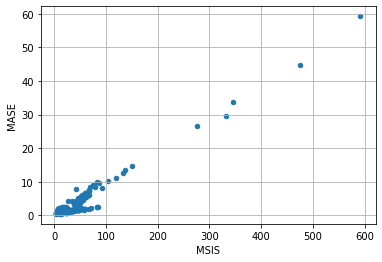

In [53]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

# Create your own forecast model
For creating your own forecast model you need to:
* Define the __training and prediction__ network
* Define a __new estimator that specifies any data processing__ and uses the networks

The training and prediction networks can be arbitrarily complex but they should follow some basic rules:
* __Both__ should have a `hybrid_forward` method that defines what should happen when the network is called
* The __training network’s__ `hybrid_forward` should __return a loss__ based on the prediction and the true values
* The __prediction__ network’s `hybrid_forward` should __return the predictions__

## Demo model

* For example, we can create a simple training network that defines a neural network:
  * which takes as an input the past values of the time series 
  * and outputs a future predicted window of length prediction_length. 
* It uses the L1 loss in the hybrid_forward method to evaluate the error among the predictions and the true values of the time series. 
* The corresponding prediction network should be identical to the training network in terms of architecture (we achieve this by inheriting the training network class), and its hybrid_forward method outputs directly the predictions.

_Note that this simple model does __only point forecasts__ by construction, i.e., we train it to outputs directly the future values of the time series and not any probabilistic view of the future (to achieve this we should train a network to learn a probability distribution and then sample from it to create sample paths)_

In [58]:
import mxnet as mx
from mxnet import nd, gpu, gluon, autograd

In [59]:
class MyTrainNetwork(gluon.HybridBlock):
    def __init__(self, prediction_length, **kwargs):
        super().__init__(**kwargs)
        self.prediction_length = prediction_length

        with self.name_scope():
            # Set up a 3 layer neural network that directly predicts the target values
            self.nn = mx.gluon.nn.HybridSequential()
            self.nn.add(mx.gluon.nn.Dense(units=40, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=40, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.prediction_length, activation='softrelu'))

    def hybrid_forward(self, F, past_target, future_target):
        prediction = self.nn(past_target)
        # calculate L1 loss with the future_target to learn the median
        return (prediction - future_target).abs().mean(axis=-1)


class MyPredNetwork(MyTrainNetwork):
    # The prediction network only receives past_target and returns predictions
    def hybrid_forward(self, F, past_target):
        prediction = self.nn(past_target)
        return prediction.expand_dims(axis=1)

Now, we need to construct the estimator which should also follow some rules:
* It should include a `create_transformation` method :
  * __defines__ all the possible feature __transformations__ and 
  * __how the data is split__ during training
* It should include a `create_training_network` method that __returns the training network configured with any necessary hyperparameters__
* It should include a `create_predictor` method that __creates the prediction network__, and returns a Predictor object. A Predictor defines the predict method of a given predictor. Roughly"
  * this method __takes the test__ dataset, 
  * it __passes it through the prediction__ network and 
  * __yields__ the predictions. 
* You can think of the __Predictor__ object as a __wrapper of the prediction network that defines its predict method__. Earlier, we used the `make_evaluation_predictions` to evaluate our predictor. 
  * Internally, the make_evaluation_predictions function invokes the predict method of the predictor to get the forecasts.

In [60]:
from gluonts.model.estimator import GluonEstimator
from gluonts.model.predictor import Predictor, RepresentableBlockPredictor
from gluonts.core.component import validated
from gluonts.support.util import copy_parameters
from gluonts.transform import ExpectedNumInstanceSampler, Transformation, InstanceSplitter
from gluonts.dataset.field_names import FieldName
from mxnet.gluon import HybridBlock

In [61]:
class MyEstimator(GluonEstimator):
    @validated()
    def __init__(
        self,
        freq: str,
        context_length: int,
        prediction_length: int,
        trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer)
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.freq = freq


    def create_transformation(self):
        # Feature transformation that the model uses for input.
        # Here we use a transformation that randomly select training samples from all time series.
        return InstanceSplitter(
                    target_field=FieldName.TARGET,
                    is_pad_field=FieldName.IS_PAD,
                    start_field=FieldName.START,
                    forecast_start_field=FieldName.FORECAST_START,
                    train_sampler=ExpectedNumInstanceSampler(num_instances=1),
                    past_length=self.context_length,
                    future_length=self.prediction_length,
                )

    def create_training_network(self) -> MyTrainNetwork:
        return MyTrainNetwork(
            prediction_length=self.prediction_length
        )

    def create_predictor(
        self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_network = MyPredNetwork(
            prediction_length=self.prediction_length
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

## Pipeline - same as before

In [62]:
estimator = MyEstimator(
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    freq=dataset.metadata.freq,
    trainer=Trainer(ctx="cpu",
                    epochs=5,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100
                   )
)

In [63]:
predictor = estimator.train(dataset.train)

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:00<00:00, 107.88it/s, epoch=5/5, avg_epoch_loss=1.29e+3]


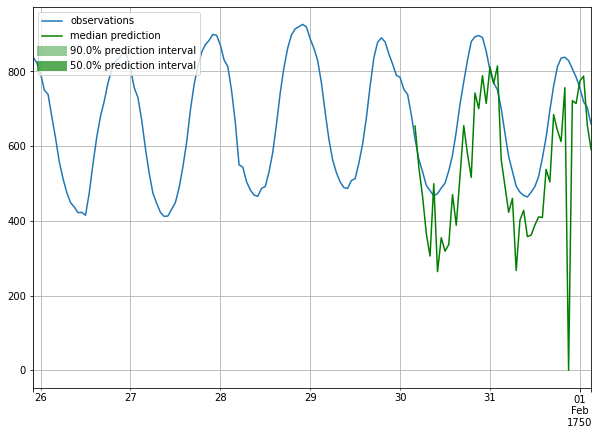

In [64]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
    num_samples=100
)

forecasts = list(forecast_it)
tss = list(ts_it)

plot_prob_forecasts(tss[0], forecasts[0])

Observe that we cannot actually see any prediction intervals in the predictions. This is expected since the model that we defined does not do probabilistic forecasting but it just gives point estimates

In [65]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))
print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 414/414 [00:00<00:00, 13098.01it/s]


{
    "MSE": 135396414.93798742,
    "abs_error": 31353583.819519043,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043147,
    "seasonal_error": 336.9046924038302,
    "MASE": 16.554518057031764,
    "MAPE": 0.5085394649433357,
    "sMAPE": 0.40239667433777615,
    "OWA": NaN,
    "MSIS": 662.1807225377123,
    "QuantileLoss[0.1]": 7413086.712162781,
    "Coverage[0.1]": 0.19202898550724629,
    "QuantileLoss[0.5]": 31353583.289009094,
    "Coverage[0.5]": 0.19202898550724629,
    "QuantileLoss[0.9]": 55294079.8658554,
    "Coverage[0.9]": 0.19202898550724629,
    "RMSE": 11635.996516757274,
    "NRMSE": 1.5885705415854938,
    "ND": 0.21540140561803056,
    "wQuantileLoss[0.1]": 0.05092844591418392,
    "wQuantileLoss[0.5]": 0.21540140197338856,
    "wQuantileLoss[0.9]": 0.3798743580325932,
    "mean_wQuantileLoss": 0.21540140197338853,
    "MAE_Coverage": 0.36932367149758455
}


In [66]:
item_metrics.head(10)

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,OWA,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,0.0,3.429095e+04,6569.344727,31644.0,659.250000,42.371302,3.230048,0.210200,0.260198,NaN,129.201926,1676.652863,0.125000,6569.344635,0.125000,11462.036407,0.125000
1,1.0,4.077165e+05,18635.851562,124149.0,2586.437500,165.107988,2.351473,0.151473,0.185008,NaN,94.058903,8187.842896,0.270833,18635.851196,0.270833,29083.859497,0.270833
2,2.0,2.400094e+05,20609.798828,65030.0,1354.791667,78.889053,5.442717,0.311132,0.388736,NaN,217.708668,4121.959619,0.000000,20609.798096,0.000000,37097.636572,0.000000
3,3.0,2.141608e+06,55479.500000,235783.0,4912.145833,258.982249,4.462943,0.236898,0.294221,NaN,178.517705,12237.232520,0.104167,55479.500488,0.104167,98721.768457,0.104167
4,4.0,5.683064e+05,27526.380859,131088.0,2731.000000,200.494083,2.860265,0.217439,0.274583,NaN,114.410614,6194.503345,0.083333,27526.381958,0.083333,48858.260571,0.083333
5,5.0,3.136331e+06,65991.750000,303379.0,6320.395833,212.875740,6.458360,0.207450,0.256146,NaN,258.334393,14975.643750,0.083333,65991.750000,0.083333,117007.856250,0.083333
6,6.0,1.481504e+08,493621.062500,1985325.0,41360.937500,1947.687870,5.279990,0.254020,0.315237,NaN,211.199588,98724.207422,0.000000,493621.037109,0.000000,888517.866797,0.000000
7,7.0,9.827862e+07,376034.250000,1540706.0,32098.041667,1624.044379,4.823789,0.246502,0.309256,NaN,192.951534,75284.427148,0.020833,376034.229492,0.020833,676784.031836,0.020833
8,8.0,8.016742e+07,311245.593750,1640860.0,34184.583333,1850.988166,3.503147,0.193775,0.240117,NaN,140.125873,79011.253125,0.125000,311245.609375,0.125000,543479.965625,0.125000
9,9.0,1.577192e+04,5156.573242,21408.0,446.000000,10.526627,10.205416,0.243365,0.298304,NaN,408.216591,1036.372623,0.020833,5156.572830,0.020833,9276.773038,0.020833


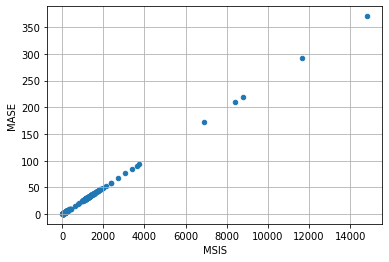

In [67]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()